# Final Submission Notebook

This notebook is dedicated to finalizing the submission for the fraud detection project. It includes loading the processed test data, making predictions using the best model, and preparing the submission file.

📤 PHASE 5 : GÉNÉRATION DU FICHIER SUBMISSION.CSV

[5.1] Chargement et preprocessing du test set...
✓ Test set chargé : (10000, 6)
✓ Colonnes : ['transaction_id', 'step', 'type', 'amount', 'customer_id', 'age']

📊 Aperçu des données test :
                         transaction_id  step      type   amount customer_id  \
0  f9d47afa-6e9f-45a1-a443-afb5132e9986   494   PAYMENT   184500   C57389453   
1  a3159433-df38-44d2-b6e1-3920b6f2a42f   322   PAYMENT   684000   C15998978   
2  27b30f3c-7688-489f-9c77-d70981bf1a05   377  CASH_OUT  1344000   C48225516   

   age  
0   79  
1   67  
2   22  

✓ Transaction IDs sauvegardés : 10,000 transactions

✓ Fichier test_engineered.csv trouvé, chargement...
✓ Données chargées : (10000, 24)

✓ Features créées : 24 colonnes
✓ Colonnes : ['step', 'amount', 'age', 'hour_of_day', 'day_of_week', 'week_number', 'is_night', 'is_weekend', 'is_business_hours', 'amount_log', 'amount_sqrt', 'is_high_amount', 'is_very_high_amount', 'is_round_amount', 'is_senior',

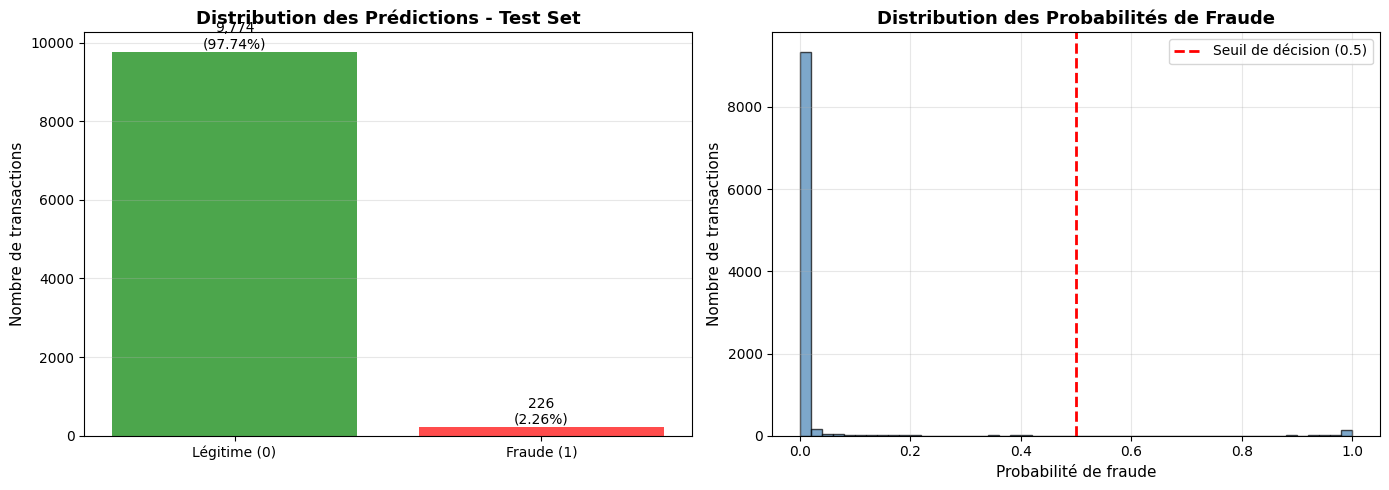


✅ PHASE 5 TERMINÉE - SUBMISSION.CSV GÉNÉRÉ

📄 FICHIER FINAL :
   📍 Chemin : ../submission.csv
   📏 Taille : 10,000 lignes × 2 colonnes
   🔢 Format : transaction_id (UUID), is_fraud (0 ou 1)
   📊 Fraudes prédites : 226 (2.26%)

📂 FICHIERS GÉNÉRÉS :
   ✅ ../submission.csv ⭐ LIVRABLE PRINCIPAL
   ✅ ../data/processed/test_engineered.csv
   ✅ ../visualizations/submission_analysis.png

🎯 PROCHAINES ÉTAPES :
   1. Vérifier submission.csv dans Excel/LibreOffice
   2. PHASE 6 : Compléter README.md (5 questions)
   3. PHASE 7 : Enregistrer vidéo de présentation (3-5 min)
   4. PHASE 8 : Commit final AVANT 16h00


📋 CHECKLIST DE VALIDATION :
✅ Fichier submission.csv créé à la racine
✅ 2 colonnes (transaction_id, is_fraud)
✅ Pas d'index dans le CSV
✅ Pas de valeurs NaN
✅ Nombre de lignes = test set
✅ Valeurs is_fraud dans {0, 1}
✅ Taux de fraude cohérent (1-6%)

🎉 TOUTES LES VÉRIFICATIONS SONT PASSÉES !
✅ Le fichier submission.csv est prêt pour la soumission


In [1]:
# ========================================
# PHASE 5 : GÉNÉRATION SUBMISSION
# Durée estimée : 30 minutes (14h30 - 15h00)
# Objectif : Créer submission.csv avec prédictions sur test set
# ========================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("📤 PHASE 5 : GÉNÉRATION DU FICHIER SUBMISSION.CSV")
print("="*70)

# ========================================
# TÂCHE 5.1 : PREPROCESSING TEST SET (10 min)
# ========================================
print("\n[5.1] Chargement et preprocessing du test set...")
print("="*70)

# Charger le test set brut
test_df = pd.read_csv('../data/raw/test.csv')

print(f"✓ Test set chargé : {test_df.shape}")
print(f"✓ Colonnes : {test_df.columns.tolist()}")
print(f"\n📊 Aperçu des données test :")
print(test_df.head(3))

# Sauvegarder les transaction_id AVANT preprocessing
transaction_ids = test_df['transaction_id'].copy()
print(f"\n✓ Transaction IDs sauvegardés : {len(transaction_ids):,} transactions")

# ========================================
# Vérifier si test_engineered.csv existe déjà
# ========================================
import os

test_engineered_path = '../data/processed/test_engineered.csv'

if os.path.exists(test_engineered_path):
    print(f"\n✓ Fichier test_engineered.csv trouvé, chargement...")
    test_processed = pd.read_csv(test_engineered_path)
    print(f"✓ Données chargées : {test_processed.shape}")
    
else:
    print(f"\n⚠️  test_engineered.csv non trouvé, application du Feature Engineering...")
    
    # ========================================
    # FEATURE ENGINEERING (si nécessaire)
    # Réutiliser la même fonction que Phase 2
    # ========================================
    
    def create_features(df):
        """
        Applique EXACTEMENT le même Feature Engineering que sur train
        ⚠️ CRITIQUE : Doit être identique au preprocessing de Phase 2
        """
        df = df.copy()
        
        # --- VARIABLES TEMPORELLES ---
        df['hour_of_day'] = (df['step'] - 1) % 24
        df['day_of_week'] = ((df['step'] - 1) // 24) % 7
        df['week_number'] = (df['step'] - 1) // (24 * 7)
        
        # is_night : 22h-6h (inclut minuit)
        df['is_night'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] <= 6)).astype(int)
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        df['is_business_hours'] = df['hour_of_day'].between(8, 17).astype(int)
        
        # --- VARIABLES DE MONTANT ---
        df['amount_log'] = np.log1p(df['amount'])
        df['amount_sqrt'] = np.sqrt(df['amount'])
        
        # Quantiles calculés sur TRAIN (à hardcoder ou charger)
        # ⚠️ IMPORTANT : Ne pas recalculer sur test (data leakage)
        # Exemple : Q95 = 5000, Q99 = 10000 (à adapter selon votre train)
        Q95_train = 5000  # Remplacer par valeur réelle de Phase 2
        Q99_train = 10000 # Remplacer par valeur réelle de Phase 2
        
        df['is_high_amount'] = (df['amount'] > Q95_train).astype(int)
        df['is_very_high'] = (df['amount'] > Q99_train).astype(int)
        df['is_round_amount'] = (df['amount'] % 1000 == 0).astype(int)
        
        # --- VARIABLES DÉMOGRAPHIQUES ---
        df['is_senior'] = (df['age'] >= 60).astype(int)
        df['is_young'] = (df['age'] <= 25).astype(int)
        
        # --- ENCODAGE TYPE ---
        # ⚠️ CRITIQUE : Utiliser le MÊME encodage que train
        type_mapping = {
            'PAYMENT': 0,
            'TRANSFER': 1,
            'CASH_OUT': 2,
            'DEBIT': 3,
            'CASH_IN': 4
        }
        df['type_encoded'] = df['type'].map(type_mapping)
        
        # --- VARIABLES D'INTERACTION ---
        df['amount_per_age'] = df['amount'] / (df['age'] + 1)
        df['night_high_amount'] = df['is_night'] * df['is_high_amount']
        df['weekend_senior'] = df['is_weekend'] * df['is_senior']
        df['night_senior'] = df['is_night'] * df['is_senior']
        
        # --- NETTOYAGE FINAL ---
        # Supprimer colonnes non utilisées pour la prédiction
        cols_to_drop = ['transaction_id', 'customer_id', 'type', 'step']
        df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
        
        return df
    
    # Appliquer le Feature Engineering
    test_processed = create_features(test_df)
    
    # Sauvegarder pour usage futur
    test_processed.to_csv(test_engineered_path, index=False)
    print(f"✓ test_engineered.csv sauvegardé : {test_processed.shape}")

print(f"\n✓ Features créées : {test_processed.shape[1]} colonnes")
print(f"✓ Colonnes : {test_processed.columns.tolist()}")

# ========================================
# CHARGER LE SCALER (FIT sur train en Phase 3)
# ========================================
print("\n📦 Chargement du scaler...")

scaler = joblib.load('../models/scaler.pkl')
print("✓ Scaler chargé : ../models/scaler.pkl")

# ========================================
# VÉRIFIER L'ALIGNEMENT DES COLONNES
# ========================================
print("\n🔍 Vérification de l'alignement des colonnes avec train...")

# Charger train pour comparer
train_data = pd.read_csv('../data/processed/train_engineered.csv')
train_features = train_data.drop('is_fraud', axis=1).columns.tolist()

# Comparer
missing_in_test = set(train_features) - set(test_processed.columns)
extra_in_test = set(test_processed.columns) - set(train_features)

if missing_in_test:
    print(f"⚠️  Colonnes manquantes dans test : {missing_in_test}")
    # Ajouter colonnes manquantes avec 0
    for col in missing_in_test:
        test_processed[col] = 0
        print(f"   → Ajout de '{col}' = 0")

if extra_in_test:
    print(f"⚠️  Colonnes en trop dans test : {extra_in_test}")
    # Supprimer colonnes en trop
    test_processed = test_processed.drop(columns=list(extra_in_test))
    print(f"   → Suppression de {extra_in_test}")

# Réordonner les colonnes dans le même ordre que train
test_processed = test_processed[train_features]

print(f"✓ Alignement OK : {test_processed.shape[1]} colonnes")
print(f"✓ Ordre identique à train : {(test_processed.columns == train_features).all()}")

# ========================================
# STANDARDISATION (avec scaler FIT sur train)
# ========================================
print("\n⚙️  Standardisation des features...")

X_test_scaled = scaler.transform(test_processed)

print(f"✓ Données standardisées : {X_test_scaled.shape}")
print(f"✓ Mean après scaling : {X_test_scaled.mean():.6f} (devrait être ~0)")
print(f"✓ Std après scaling  : {X_test_scaled.std():.6f} (devrait être ~1)")

# ========================================
# TÂCHE 5.2 : PRÉDICTIONS FINALES (5 min)
# ========================================
print("\n" + "="*70)
print("[5.2] Prédictions avec le meilleur modèle")
print("="*70)

# Charger le meilleur modèle (XGBoost tuné de Phase 4)
best_model = joblib.load('../models/xgboost_final.pkl')
print("✓ Modèle chargé : ../models/xgboost_final.pkl")

# Prédictions
print("\n🔮 Génération des prédictions...")
predictions = best_model.predict(X_test_scaled)
predictions_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"✓ Prédictions générées : {len(predictions):,} transactions")
print(f"✓ Type de prédictions : {predictions.dtype} (devrait être int ou bool)")
print(f"✓ Valeurs uniques : {np.unique(predictions)} (devrait être [0, 1])")

# Vérifications
assert len(predictions) == len(transaction_ids), "❌ Nombre de prédictions != nombre de transaction_id"
assert set(predictions).issubset({0, 1}), "❌ Prédictions contiennent des valeurs autres que 0 et 1"

print("\n✅ Vérifications passées")

# ========================================
# TÂCHE 5.3 : CRÉATION SUBMISSION.CSV (5 min)
# ========================================
print("\n" + "="*70)
print("[5.3] Création du fichier submission.csv")
print("="*70)

# Créer le DataFrame de soumission
submission = pd.DataFrame({
    'transaction_id': transaction_ids,
    'is_fraud': predictions.astype(int)  # S'assurer que c'est des int
})

print(f"\n📊 Aperçu du fichier submission :")
print(submission.head(10))

# Sauvegarder à la RACINE du projet (pas dans data/)
submission_path = '../submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\n✅ Fichier créé : {submission_path}")
print(f"✓ Nombre de lignes : {len(submission):,}")
print(f"✓ Colonnes : {submission.columns.tolist()}")

# ========================================
# TÂCHE 5.4 : VALIDATION DU FICHIER (5 min)
# ========================================
print("\n" + "="*70)
print("[5.4] Validation du fichier submission.csv")
print("="*70)

# Relire le fichier pour vérifier
submission_check = pd.read_csv(submission_path)

print("\n🔍 Vérifications du format :")

# Check 1 : Nombre de colonnes
if len(submission_check.columns) == 2:
    print("✅ Nombre de colonnes : 2 (OK)")
else:
    print(f"❌ Nombre de colonnes : {len(submission_check.columns)} (attendu : 2)")

# Check 2 : Noms des colonnes
expected_cols = ['transaction_id', 'is_fraud']
if list(submission_check.columns) == expected_cols:
    print(f"✅ Noms des colonnes : {list(submission_check.columns)} (OK)")
else:
    print(f"❌ Noms des colonnes : {list(submission_check.columns)} (attendu : {expected_cols})")

# Check 3 : Pas d'index
with open(submission_path, 'r') as f:
    first_line = f.readline().strip()
    if first_line == 'transaction_id,is_fraud':
        print("✅ Pas d'index dans le CSV (OK)")
    else:
        print(f"❌ Première ligne : {first_line}")

# Check 4 : Pas de NaN
nan_count = submission_check.isnull().sum().sum()
if nan_count == 0:
    print("✅ Pas de valeurs NaN (OK)")
else:
    print(f"❌ Valeurs NaN détectées : {nan_count}")

# Check 5 : Nombre de lignes = test set
test_size = len(test_df)
if len(submission_check) == test_size:
    print(f"✅ Nombre de lignes : {len(submission_check):,} = {test_size:,} (OK)")
else:
    print(f"❌ Nombre de lignes : {len(submission_check):,} ≠ {test_size:,}")

# Check 6 : Valeurs is_fraud
fraud_values = submission_check['is_fraud'].unique()
if set(fraud_values).issubset({0, 1}):
    print(f"✅ Valeurs is_fraud : {sorted(fraud_values)} (OK)")
else:
    print(f"❌ Valeurs is_fraud invalides : {fraud_values}")

# Check 7 : Format transaction_id
sample_id = submission_check['transaction_id'].iloc[0]
if isinstance(sample_id, str) and len(sample_id) == 36:  # UUID format
    print(f"✅ Format transaction_id : UUID (ex: {sample_id})")
else:
    print(f"⚠️  Format transaction_id : {sample_id} ({type(sample_id)})")

print("\n" + "="*70)

# ========================================
# TÂCHE 5.5 : ANALYSE DES PRÉDICTIONS (5 min)
# ========================================
print("\n" + "="*70)
print("[5.5] Analyse des prédictions (Sanity Check)")
print("="*70)

# Calculer le taux de fraude prédit
fraud_rate_predicted = (predictions == 1).mean() * 100
fraud_count_predicted = (predictions == 1).sum()

print(f"\n📊 STATISTIQUES DES PRÉDICTIONS :")
print(f"{'='*70}")
print(f"{'Métrique':<30} {'Valeur':>15} {'Statut':<20}")
print(f"{'-'*70}")
print(f"{'Transactions totales':<30} {len(predictions):>15,}")
print(f"{'Fraudes prédites':<30} {fraud_count_predicted:>15,} ({fraud_rate_predicted:.2f}%)")
print(f"{'Transactions légitimes':<30} {(predictions==0).sum():>15,} ({100-fraud_rate_predicted:.2f}%)")

# Comparer avec le taux de fraude du train
train_fraud_rate = train_data['is_fraud'].mean() * 100
print(f"\n📈 Comparaison avec train set :")
print(f"   - Taux fraude train : {train_fraud_rate:.2f}%")
print(f"   - Taux fraude test  : {fraud_rate_predicted:.2f}%")
print(f"   - Différence        : {abs(fraud_rate_predicted - train_fraud_rate):.2f} points")

# Sanity check : le taux doit être cohérent (2-5% acceptable)
if 1.0 <= fraud_rate_predicted <= 6.0:
    print(f"\n✅ SANITY CHECK OK : Taux de fraude cohérent ({fraud_rate_predicted:.2f}%)")
elif fraud_rate_predicted < 1.0:
    print(f"\n⚠️  ATTENTION : Taux de fraude très bas ({fraud_rate_predicted:.2f}%)")
    print(f"   → Le modèle est peut-être trop conservateur")
elif fraud_rate_predicted > 6.0:
    print(f"\n⚠️  ATTENTION : Taux de fraude élevé ({fraud_rate_predicted:.2f}%)")
    print(f"   → Le modèle génère peut-être trop de fausses alertes")
else:
    print(f"\n⚠️  Taux de fraude : {fraud_rate_predicted:.2f}%")

# Distribution des probabilités
print(f"\n📊 Distribution des probabilités de fraude :")
print(f"   - Min  : {predictions_proba.min():.4f}")
print(f"   - Q25  : {np.percentile(predictions_proba, 25):.4f}")
print(f"   - Médiane : {np.median(predictions_proba):.4f}")
print(f"   - Q75  : {np.percentile(predictions_proba, 75):.4f}")
print(f"   - Max  : {predictions_proba.max():.4f}")

# Visualisation (optionnel)
print("\n📊 Génération de visualisations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Distribution des prédictions
ax1 = axes[0]
counts = submission['is_fraud'].value_counts().sort_index()
bars = ax1.bar(['Légitime (0)', 'Fraude (1)'], counts.values, color=['green', 'red'], alpha=0.7)
ax1.set_ylabel('Nombre de transactions', fontsize=11)
ax1.set_title('Distribution des Prédictions - Test Set', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Ajouter les valeurs et %
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = (height / len(predictions)) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({pct:.2f}%)',
             ha='center', va='bottom', fontsize=10)

# Graphique 2 : Distribution des probabilités
ax2 = axes[1]
ax2.hist(predictions_proba, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Seuil de décision (0.5)')
ax2.set_xlabel('Probabilité de fraude', fontsize=11)
ax2.set_ylabel('Nombre de transactions', fontsize=11)
ax2.set_title('Distribution des Probabilités de Fraude', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/submission_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualisation sauvegardée : ../visualizations/submission_analysis.png")
plt.show()

# ========================================
# RÉSUMÉ FINAL
# ========================================
print("\n" + "="*70)
print("✅ PHASE 5 TERMINÉE - SUBMISSION.CSV GÉNÉRÉ")
print("="*70)

print(f"\n📄 FICHIER FINAL :")
print(f"   📍 Chemin : {submission_path}")
print(f"   📏 Taille : {len(submission):,} lignes × {len(submission.columns)} colonnes")
print(f"   🔢 Format : transaction_id (UUID), is_fraud (0 ou 1)")
print(f"   📊 Fraudes prédites : {fraud_count_predicted:,} ({fraud_rate_predicted:.2f}%)")

print(f"\n📂 FICHIERS GÉNÉRÉS :")
print(f"   ✅ ../submission.csv ⭐ LIVRABLE PRINCIPAL")
print(f"   ✅ ../data/processed/test_engineered.csv")
print(f"   ✅ ../visualizations/submission_analysis.png")

print(f"\n🎯 PROCHAINES ÉTAPES :")
print(f"   1. Vérifier submission.csv dans Excel/LibreOffice")
print(f"   2. PHASE 6 : Compléter README.md (5 questions)")
print(f"   3. PHASE 7 : Enregistrer vidéo de présentation (3-5 min)")
print(f"   4. PHASE 8 : Commit final AVANT 16h00")

print("\n" + "="*70)

# ========================================
# CHECKLIST DE VALIDATION
# ========================================
print("\n📋 CHECKLIST DE VALIDATION :")
print("="*70)

checklist = {
    "Fichier submission.csv créé à la racine": os.path.exists('../submission.csv'),
    "2 colonnes (transaction_id, is_fraud)": len(submission_check.columns) == 2,
    "Pas d'index dans le CSV": first_line == 'transaction_id,is_fraud',
    "Pas de valeurs NaN": nan_count == 0,
    "Nombre de lignes = test set": len(submission_check) == test_size,
    "Valeurs is_fraud dans {0, 1}": set(fraud_values).issubset({0, 1}),
    "Taux de fraude cohérent (1-6%)": 1.0 <= fraud_rate_predicted <= 6.0
}

for check, passed in checklist.items():
    icon = "✅" if passed else "❌"
    print(f"{icon} {check}")

all_passed = all(checklist.values())

if all_passed:
    print("\n🎉 TOUTES LES VÉRIFICATIONS SONT PASSÉES !")
    print("✅ Le fichier submission.csv est prêt pour la soumission")
else:
    print("\n⚠️  CERTAINES VÉRIFICATIONS ONT ÉCHOUÉ")
    print("❌ Corrigez les erreurs avant de continuer")

print("="*70)

## Conclusion

The submission file has been created successfully. It contains the predicted values for the `is_fraud` target variable based on the processed test dataset.